<a href="https://colab.research.google.com/github/Ishita05Goel/StockMarketPredictionModel/blob/main/StockMarketPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Fetching data for RELIANCE.NS...


[*********************100%***********************]  1 of 1 completed


Saved RELIANCE.NS_daily.csv and RELIANCE.NS_weekly.csv


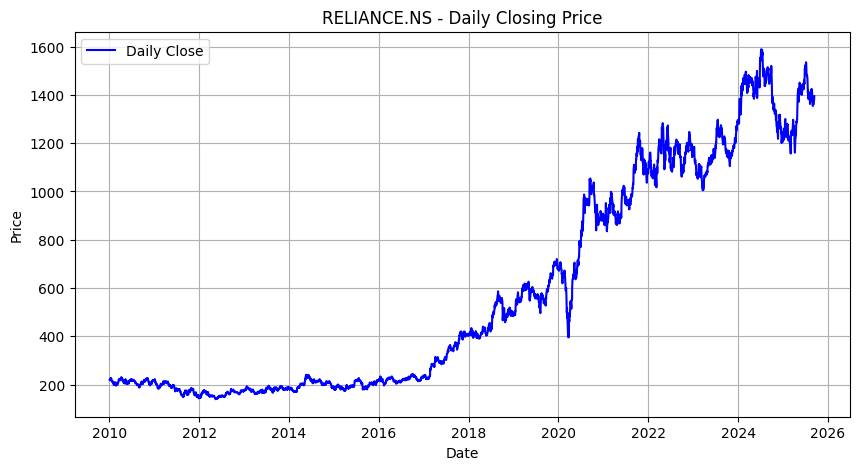

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


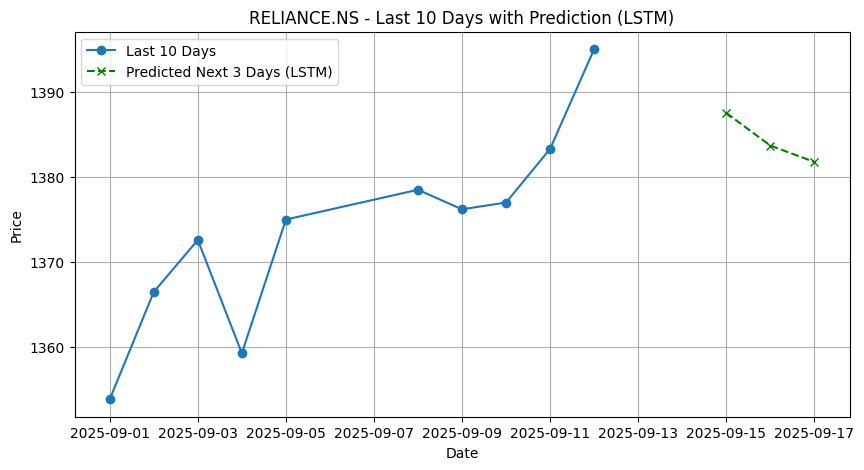

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


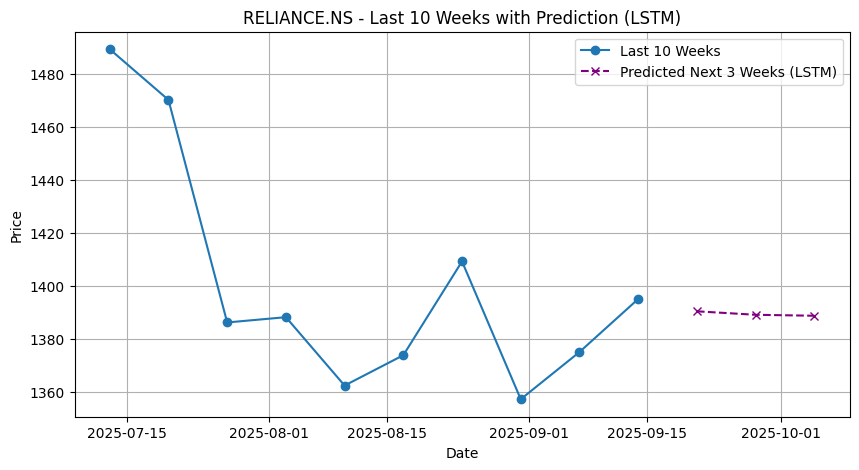

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

def fetch_and_process_stock(ticker, start_date="2010-01-01"):
    print(f"\nFetching data for {ticker}...")

    # Download daily data
    df = yf.download(ticker, start=start_date, progress=True, auto_adjust=True)

    # Flatten MultiIndex columns if present
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [col[0] for col in df.columns]

    # Ensure datetime index
    df.index = pd.to_datetime(df.index)

    # Choose price column
    price_col = "Close" if "Close" in df.columns else "Adj Close"

    # Resample to week-end
    weekly_df = df.resample("W").agg({price_col: "last"})
    weekly_df.rename(columns={price_col: "Close"}, inplace=True)

    # Save CSVs
    df.to_csv(f"{ticker}_daily.csv")
    weekly_df.to_csv(f"{ticker}_weekly.csv")
    print(f"Saved {ticker}_daily.csv and {ticker}_weekly.csv")

    # ----------------------------
    # Graph 1: Daily Closing Price
    # ----------------------------
    plt.figure(figsize=(10,5))
    plt.plot(df.index, df[price_col], color="blue", label="Daily Close")
    plt.title(f"{ticker} - Daily Closing Price")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

    # ----------------------------
    # Graph 2: Last 10 Days + Predict next 3 days (LSTM)
    # ----------------------------
    last_10_days = df.tail(10).copy()
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(last_10_days[[price_col]])

    X, y = [], []
    for i in range(len(scaled_data)-1):
        X.append(scaled_data[i])
        y.append(scaled_data[i+1])
    X, y = np.array(X), np.array(y)
    X = X.reshape((X.shape[0], 1, X.shape[1]))  # reshape for LSTM

    model = Sequential([
        LSTM(50, activation="relu", input_shape=(X.shape[1], X.shape[2])),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    model.fit(X, y, epochs=200, verbose=0)

    # Predict next 3 days
    last_value = scaled_data[-1].reshape(1,1,1)
    preds_scaled = []
    for _ in range(3):
        pred = model.predict(last_value, verbose=0)
        preds_scaled.append(pred[0][0])
        last_value = pred.reshape(1,1,1)

    future_preds = scaler.inverse_transform(np.array(preds_scaled).reshape(-1,1)).flatten()
    future_dates = pd.date_range(last_10_days.index[-1] + pd.Timedelta(days=1), periods=3, freq="B")

    plt.figure(figsize=(10,5))
    plt.plot(last_10_days.index, last_10_days[price_col], marker="o", label="Last 10 Days")
    plt.plot(future_dates, future_preds, marker="x", linestyle="--", color="green", label="Predicted Next 3 Days (LSTM)")
    plt.title(f"{ticker} - Last 10 Days with Prediction (LSTM)")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

    # ----------------------------
    # Graph 3: Last 10 Weeks + Predict next 3 weeks (LSTM)
    # ----------------------------
    last_10_weeks = df.resample("W").agg({price_col: "last"}).tail(10).copy()
    scaler_w = MinMaxScaler()
    scaled_data_w = scaler_w.fit_transform(last_10_weeks[["Close"]])

    X_w, y_w = [], []
    for i in range(len(scaled_data_w)-1):
        X_w.append(scaled_data_w[i])
        y_w.append(scaled_data_w[i+1])
    X_w, y_w = np.array(X_w), np.array(y_w)
    X_w = X_w.reshape((X_w.shape[0], 1, X_w.shape[1]))

    model_w = Sequential([
        LSTM(50, activation="relu", input_shape=(X_w.shape[1], X_w.shape[2])),
        Dense(1)
    ])
    model_w.compile(optimizer="adam", loss="mse")
    model_w.fit(X_w, y_w, epochs=200, verbose=0)

    # Predict next 3 weeks
    last_value_w = scaled_data_w[-1].reshape(1,1,1)
    preds_scaled_w = []
    for _ in range(3):
        pred_w = model_w.predict(last_value_w, verbose=0)
        preds_scaled_w.append(pred_w[0][0])
        last_value_w = pred_w.reshape(1,1,1)

    future_preds_w = scaler_w.inverse_transform(np.array(preds_scaled_w).reshape(-1,1)).flatten()
    future_weeks = pd.date_range(last_10_weeks.index[-1] + pd.Timedelta(weeks=1), periods=3, freq="W")

    plt.figure(figsize=(10,5))
    plt.plot(last_10_weeks.index, last_10_weeks["Close"], marker="o", label="Last 10 Weeks")
    plt.plot(future_weeks, future_preds_w, marker="x", linestyle="--", color="purple", label="Predicted Next 3 Weeks (LSTM)")
    plt.title(f"{ticker} - Last 10 Weeks with Prediction (LSTM)")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

    return df, weekly_df

# Example usage
daily, weekly = fetch_and_process_stock("RELIANCE.NS")
